# TODO

- Написать про то как генерируется сектрограмма (оконное преобразование фурье) и откуда берутся её размерности
- Написать про то как генерируется Mel-спектрограмма  и почему её размерности отличаются
- Написать про ансамблирование нейросетей (https://arxiv.org/abs/2008.10400v2)
- Добавить в "Вместо введения" про источник датасета (откуда записи и почему датасеты A и B отличаются)
---



# Вместо введения #
Статистические методы обработки сигналов из области музыкальной акустики [Chauhan, 2020] оцениваем на применимость к задачам автоматического выделения (и не дай бог классификации) звуков морских млекопитающих. Задача выделения звуков морских обитателей является актуальной, о чем свидетельствуют свежии публикации в данной области [Ibrahim, 2018; Meridian, 2019; Kirsebom, 2020]. Конечно, эта задача могла бы решаться вручную, и так и делается на первых этапах[Watkins], однако далее, чтобы упростить жизнь операторов при  обработке больших объемов данных или чтобы создать автономный регистратор с экономией энергии и объема внутренней памяти, представлется интерес автоматизировать этот процесс [Kirsebom, 2020].

В данном блокноте мы используем данные [Kirsebom-data, 2015-19], содержащие реальные записи китов вида "North Atlantic right whale" ("Северный гладкий кит"), которые были любезно предоставлены всей научной общественности авторами исследования [Kirsebom, 2020].


> [Ibrahim,2018]https://doi.org/10.1121/1.5022281 ; <br>
> [Chauhan,2020]https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html ; <br>
> [Kirsebom-data,2015-19]https://doi.org/10.20383/101.0241 ; <br>
> [Kirsebom,2020]https://doi.org/10.1121/10.0001132 ; <br>
> [Watkins]https://cis.whoi.edu/science/B/whalesounds/about.cfm; <br>
> [Meridian,2019]https://meridian.cs.dal.ca/detecting-underwater-sounds-with-deep-learning/ ; <br>

Для использования данных нужно примонтировать гугл диск следуюещй командой:

### Вспомагательные функции и загрузка данных

In [367]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchvision.models as models
import librosa
import warnings
import random
from torchaudio import transforms as audio_transforms
from torch import optim
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms as vision_transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm.notebook import tqdm
from PIL import Image, ImageDraw
from typing import List, Dict, Tuple, Union
from sklearn.metrics import roc_auc_score

warnings.filterwarnings('ignore')

SEED = 21

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(torch.__version__)
print(torchaudio.__version__)

1.9.0+cu102
0.9.0


In [113]:
def open(audio_file):
    y, sr = torchaudio.load(audio_file)
    return (y, sr)

def spectrogram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    top_db = 8
    
    spec = audio_transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    spec = audio_transforms.AmplitudeToDB(top_db=top_db)(spec)
    
    return spec

def getMetrics(Y_files_test, files_preds, output=True, threshold=0.5) -> Tuple:
    rms = np.sqrt(mean_squared_error(Y_files_test, files_preds))
    precision = precision_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    recall = recall_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    accuracy = accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    balanced_accuracy = balanced_accuracy_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    f1 = f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold))
    f1_weighted = f1_score(Y_files_test,  binarize(files_preds.reshape(-1, 1), threshold=threshold), average = 'weighted')
    auc_roc = roc_auc_score(Y_files_test,  files_preds)
    if output:
        print(f"RMS: {rms}\n"
              f"Precision score: {precision}\n"
              f"Recall score: {recall}\n"
              f"Accuracy score: {accuracy}\n"
              f"Balanced accuracy score: {balanced_accuracy}\n"
              f"F1 score: {f1}\n"
              f"F1 weighted score: {f1_weighted}\n"
              f"AUC-ROC score: {auc_roc}")
    return (rms, precision, recall, accuracy, balanced_accuracy, f1, f1_weighted, auc_roc)

In [256]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm.notebook import tqdm

df = pd.read_csv('/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv', sep=';')

display(df.sample(10))
display(df.describe())

,clip_name,label,snr
2111,B_2478.wav,1,6.84
2317,B_2714.wav,0,5.86
2394,B_2804.wav,1,4.08
1159,B_1369.wav,1,8.83
2181,B_2562.wav,1,12.56
338,B_403.wav,1,3.94
527,B_622.wav,1,6.22
1021,B_1199.wav,1,14.91
2785,B_3276.wav,0,16.62
2915,B_3424.wav,1,12.10


,label,snr
count,3309.000000,3309.000000
mean,0.614385,9.460719
std,0.486814,5.018798
min,0.000000,-6.040000
25%,0.000000,5.960000
50%,1.000000,8.580000
75%,1.000000,12.080000
max,1.000000,42.270000


In [257]:
display(df.drop(["label"], axis=1))
display(df["label"])

,clip_name,snr
0,B_0.wav,-1.91
1,B_1.wav,7.01
2,B_2.wav,13.80
3,B_3.wav,8.42
4,B_5.wav,14.45
...,...,...
3304,B_3886.wav,12.38
3305,B_3887.wav,6.58
3306,B_3888.wav,18.81
3307,B_3889.wav,16.99


0       0
1       0
2       0
3       0
4       0
       ..
3304    0
3305    0
3306    1
3307    1
3308    1
Name: label, Length: 3309, dtype: int64

In [258]:
display(df.iloc[122]["clip_name"])

'B_146.wav'

In [259]:
import matplotlib
import matplotlib.pyplot as plt

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

1) Waveform: tensor([[-0.0015, -0.0035, -0.0028,  ..., -0.0005, -0.0005, -0.0002]])
Sample rate: 1000
Size = torch.Size([1, 3001])
Mel-Spectrogram as tensor: tensor([[[6.9734e-02, 3.0018e-02, 7.1928e-02,  ..., 2.9300e-02,
          1.5128e-01, 1.3073e-02],
         [2.3407e-02, 4.2571e-02, 1.1917e-02,  ..., 1.7398e-02,
          1.5499e-01, 1.1981e-02],
         [1.6690e-02, 1.0467e-02, 6.3661e-03,  ..., 1.0467e-02,
          4.7400e-02, 1.0636e-02],
         ...,
         [7.9164e-06, 4.3600e-06, 1.7847e-06,  ..., 2.2662e-06,
          1.1787e-05, 5.9423e-06],
         [1.2207e-06, 7.5166e-06, 3.4760e-06,  ..., 8.4543e-06,
          6.7600e-06, 2.0813e-06],
         [7.0303e-06, 3.8965e-06, 7.6736e-07,  ..., 1.4465e-05,
          1.1086e-05, 1.4282e-05]]]), shape: torch.Size([1, 128, 16])


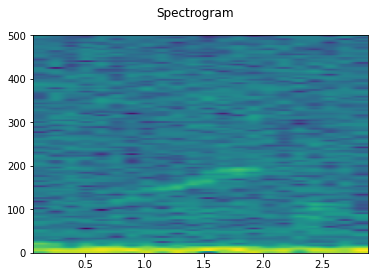

2) Waveform: tensor([[-0.0099, -0.0212, -0.0180,  ..., -0.0348, -0.0406, -0.0190]])
Sample rate: 1000
Size = torch.Size([1, 3001])
Mel-Spectrogram as tensor: tensor([[[1.8708e+00, 1.3008e+00, 1.1726e+00,  ..., 5.0379e+00,
          1.3756e+00, 5.3317e+00],
         [7.0451e+00, 2.0222e+00, 1.2513e+00,  ..., 4.0951e+00,
          1.7466e-01, 1.8237e+00],
         [3.5251e+00, 6.2898e-01, 4.8672e-01,  ..., 6.6303e-01,
          7.1583e-02, 6.1993e-01],
         ...,
         [8.9539e-04, 1.8594e-05, 1.6757e-05,  ..., 2.5482e-05,
          4.1692e-05, 1.5396e-03],
         [7.5649e-04, 2.8497e-05, 3.4079e-06,  ..., 2.1098e-05,
          3.9266e-05, 2.2490e-03],
         [8.5662e-04, 1.2956e-05, 2.9761e-06,  ..., 1.3078e-05,
          1.1814e-05, 2.2001e-03]]]), shape: torch.Size([1, 128, 16])


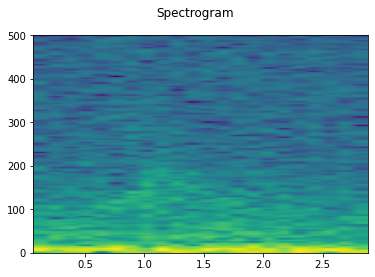

3) Waveform: tensor([[ 0.0010, -0.0016,  0.0005,  ..., -0.0043, -0.0039, -0.0019]])
Sample rate: 1000
Size = torch.Size([1, 3001])
Mel-Spectrogram as tensor: tensor([[[5.5311e-03, 7.1473e-03, 3.0640e-02,  ..., 2.3820e-03,
          2.6740e-03, 2.7447e-02],
         [9.8310e-04, 9.5891e-05, 9.5221e-03,  ..., 2.9694e-03,
          5.7646e-03, 1.1239e-02],
         [4.1259e-04, 2.1352e-04, 2.7446e-03,  ..., 1.5046e-03,
          2.2757e-03, 3.8139e-04],
         ...,
         [2.1720e-04, 2.4938e-04, 1.0705e-04,  ..., 1.4293e-04,
          6.1649e-05, 1.2685e-04],
         [5.8740e-04, 5.0423e-04, 1.1981e-04,  ..., 2.7734e-04,
          2.2318e-04, 3.0369e-05],
         [1.1115e-04, 1.7642e-03, 2.5171e-04,  ..., 4.5088e-04,
          2.9645e-04, 6.6174e-04]]]), shape: torch.Size([1, 128, 16])


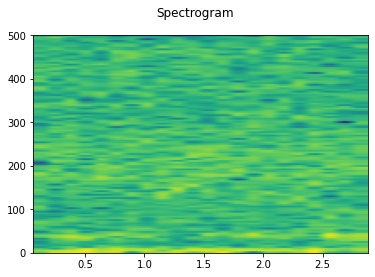

In [260]:
for i in range(3):
    waveform, sample_rate = open('/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/' + df['clip_name'][random.randint(1, 1000)])
    mel_spectrogram = audio_transforms.MelSpectrogram(sample_rate)(waveform)
    print(f"{i+1}) Waveform: {waveform}\nSample rate: {sample_rate}\nSize = {waveform.shape}")
    print(f"Mel-Spectrogram as tensor: {mel_spectrogram}, shape: {mel_spectrogram.shape}")
    plot_specgram(waveform, sample_rate)

In [283]:
class AudioDataset(Dataset):
    def __init__(self, dataframe, audio_path):
        self.df = dataframe
        self.files_path = audio_path

    def __len__(self):
        return len(self.df)    

    def __getitem__(self, idx):

        waveform, sample_rate = torchaudio.load(self.files_path + self.df['clip_name'][idx])
        
        mel_spectrogram = audio_transforms.MelSpectrogram(sample_rate, normalized=True)(waveform)

        # convert 1 channel to 3 channels applying imagenet models
        mel_spectrogram = mel_spectrogram.repeat(3, 1, 1)
        
        # Applying audio augmentations by converting to numpy array
        mel_spectrogram = np.transpose(mel_spectrogram.numpy(), (1,2,0))
        
        # As torch accepts channels first so applying this
        mel_spectrogram = np.transpose(mel_spectrogram,(2,0,1)).astype(np.float32)

        label = self.df['label'][idx]
        
        return torch.tensor(mel_spectrogram, dtype = torch.float), torch.tensor(label, dtype = torch.float)

In [263]:
df = pd.read_csv('/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv', sep=';')

WhalesDataset = AudioDataset(df, "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/")

In [264]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [265]:
import random

indexes = list(range(0, len(WhalesDataset)))

train_index = indexes[:round(0.8 * len(WhalesDataset))]
test_index = indexes[round(0.8 * len(WhalesDataset)):]

train = AudioDataset(df.iloc[train_index])
test = AudioDataset(df.iloc[test_index].reset_index())

display(len(train))
display(len(test))

2647

662

In [266]:
train_loader = DataLoader(train, shuffle=True)
test_loader = DataLoader(test, shuffle=False)

In [331]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(6, 2), padding=(3, 2))
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(6, 2), padding=(3, 2))
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(6, 2), padding=(3, 2))
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(6, 2), padding=(3, 2))
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(6, 2), padding=(3, 2))
        self.bn5 = nn.BatchNorm2d(512)
        
        self.maxpool = nn.MaxPool2d(kernel_size=(4, 2), stride=(2, 2))
        self.avg = nn.AvgPool2d((2, 3))
        self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(512, 1)
        
    def forward(self, x):
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn3(self.conv3(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn4(self.conv4(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn5(self.conv5(x)))))
        x = self.avg(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

In [268]:
model_1 = CNN1()
learning_rate = 0.01
device = ("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)
epochs = 20

In [308]:
def train(model,
          model_name,
          epochs, 
          train_loader, 
          test_loader, 
          criterion, 
          optimizer):

    train_loss_history = np.empty(0)
    train_roc_auc_history = np.empty(0)
    test_loss_history = np.empty(0)
    test_roc_auc_history = np.empty(0)
    best_roc_auc = 0.5
    iterations_per_train_epoch = len(train_loader)
    test_final_predictions = torch.empty(0, device=device)

    model.train()
    for epoch in range(epochs):
        train_preds = torch.empty(0, device=device)
        train_labels = torch.empty(0, device=device)
        for data, label in tqdm(train_loader, total=iterations_per_train_epoch):
            data, label = data.to(device).float(), label.to(device).float()
            optimizer.zero_grad()
            preds = torch.as_tensor(model(data)[0])
            loss = criterion(preds, label)
            loss.backward()
            optimizer.step()
            train_preds = torch.cat((train_preds, preds))
            train_labels = torch.cat((train_labels, label))

        train_preds = torch.squeeze(train_preds)
        train_labels = torch.squeeze(train_labels)

        loss = criterion(train_preds, train_labels)
        roc_auc = roc_auc_score(train_labels.cpu().detach().numpy(), train_preds.cpu().detach().numpy())
        train_loss_history = np.append(train_loss_history, loss.cpu().detach().numpy())
        train_roc_auc_history = np.append(train_roc_auc_history, roc_auc)
        print(f"Epoch: {epoch + 1}\nTrain Loss = {loss}, Train ROC-AUC = {roc_auc}")

        with torch.no_grad():
            test_preds = torch.empty(0, device=device)
            test_labels = torch.empty(0, device=device)
            for data, label in test_loader:
                data, label = data.to(device).float(), label.to(device).float()
                preds = torch.as_tensor(model(data)[0])
                loss = criterion(preds, label)
                test_preds = torch.cat((test_preds, preds))
                test_labels = torch.cat((test_labels, label))

            test_preds = torch.squeeze(test_preds)
            test_labels = torch.squeeze(test_labels)

            loss = criterion(test_preds, test_labels)
            roc_auc = roc_auc_score(test_labels.cpu().detach().numpy(), test_preds.cpu().detach().numpy())
            test_loss_history = np.append(test_loss_history, loss.cpu().detach().numpy())
            test_roc_auc_history = np.append(test_roc_auc_history, roc_auc)

            print(f"Test Loss = {loss}, Test ROC-AUC = {roc_auc}")

            if roc_auc > best_roc_auc:
                torch.save(model.state_dict(), "best_roc_auc_" + model_name + ".pth")
                print("Model saved successfully\n")
                best_roc_auc = roc_auc
                test_final_predictions = test_preds
            else:
                print()

    torch.save(model.state_dict(), "final_" + model_name + ".pth")
    model.eval()
    
    return (model, 
            test_final_predictions, 
            train_loss_history, 
            train_roc_auc_history, 
            test_loss_history, 
            test_roc_auc_history, 
            best_roc_auc)

In [270]:
%%time
(model_1, 
test_final_predictions, 
train_loss_history, 
train_roc_auc_history, 
test_loss_history, 
test_roc_auc_history, 
best_roc_auc) = train(model_1, epochs, train_loader, test_loader, criterion, optimizer)

  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.7172744870185852, Train ROC-AUC = 0.4890540957003694
Test Loss = 0.6668931841850281, Test ROC-AUC = 0.5295669569082985
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6712492108345032, Train ROC-AUC = 0.5312639946260636
Test Loss = 0.635352611541748, Test ROC-AUC = 0.6530919914570388
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6043614149093628, Train ROC-AUC = 0.7127785081066504
Test Loss = 0.6930028200149536, Test ROC-AUC = 0.7450834484958009
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.54450523853302, Train ROC-AUC = 0.7834438457352807
Test Loss = 0.546114444732666, Test ROC-AUC = 0.7861070576070044
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.5089148879051208, Train ROC-AUC = 0.8185646389205901
Test Loss = 0.4923785924911499, Test ROC-AUC = 0.8320689621848334
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.47190767526626587, Train ROC-AUC = 0.846384751696209
Test Loss = 0.4890119135379791, Test ROC-AUC = 0.8402736840070739
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.46157100796699524, Train ROC-AUC = 0.8550397507572147
Test Loss = 0.447656512260437, Test ROC-AUC = 0.8630033727301719
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.4339107871055603, Train ROC-AUC = 0.8731557189566088
Test Loss = 0.47140687704086304, Test ROC-AUC = 0.8637958193608242
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.43747827410697937, Train ROC-AUC = 0.8731153903567697
Test Loss = 0.46118223667144775, Test ROC-AUC = 0.8609546082704369



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.41463416814804077, Train ROC-AUC = 0.8855293760744261
Test Loss = 0.4945128262042999, Test ROC-AUC = 0.8636605235946151



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.4122055768966675, Train ROC-AUC = 0.8871912755394402
Test Loss = 0.44775569438934326, Test ROC-AUC = 0.8790649129758303
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.4136865437030792, Train ROC-AUC = 0.8871045991457561
Test Loss = 0.4073909521102905, Test ROC-AUC = 0.890652028953294
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.39171841740608215, Train ROC-AUC = 0.898669878508588
Test Loss = 0.500025749206543, Test ROC-AUC = 0.8721744928824762



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.38935887813568115, Train ROC-AUC = 0.8998285733547136
Test Loss = 0.4717962145805359, Test ROC-AUC = 0.8852401983049373



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.38028430938720703, Train ROC-AUC = 0.9051549581304865
Test Loss = 0.4359966516494751, Test ROC-AUC = 0.8844960715907882



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.3803445100784302, Train ROC-AUC = 0.9055335654334542
Test Loss = 0.43223169445991516, Test ROC-AUC = 0.8966340346163881
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.37545838952064514, Train ROC-AUC = 0.9082319701062749
Test Loss = 0.43228453397750854, Test ROC-AUC = 0.8978323685456673
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.3655329644680023, Train ROC-AUC = 0.9124881421878085
Test Loss = 0.4938497543334961, Test ROC-AUC = 0.8940634150584187



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.36209163069725037, Train ROC-AUC = 0.91418856449446
Test Loss = 0.4191361963748932, Test ROC-AUC = 0.8965373947833817



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.3530952036380768, Train ROC-AUC = 0.9194619803629815
Test Loss = 0.4080077111721039, Test ROC-AUC = 0.9086946857755831
Model saved successfully

CPU times: user 9h 18min 23s, sys: 5min 6s, total: 9h 23min 30s
Wall time: 50min 21s


In [402]:
def process_predictions(predictions: np.array, threshold: float) -> np.array:
    new_predictions = predictions.copy()
    for i in range(len(predictions)):
        new_predictions[i] = 1.0 if new_predictions[i] > threshold else 0.0
    return new_predictions

def find_best_threshold(labels: np.array, predictions: np.array) -> (np.array, float, float):
    best_threshold, best_roc_auc = 0, 0
    best_predictions = predictions.copy()
    for threshold in np.linspace(0.01, 0.99, 30):
        current_predictions = process_predictions(predictions, threshold)
        current_roc_auc = roc_auc_score(labels, current_predictions)
        if current_roc_auc > best_roc_auc:
            best_roc_auc = current_roc_auc
            best_threshold = threshold
            best_predictions = current_predictions
    return best_predictions, best_threshold, best_roc_auc

In [271]:
test_labels = torch.empty(0, device=device)
for data, label in test_loader:
    test_labels = torch.cat((test_labels, label))
test_labels = torch.squeeze(test_labels)
# test_predictions = test_final_predictions
# print(f"Best ROC-AUC without post-processing= {roc_auc_score(test_labels, test_final_predictions)}")
# test_predictions, test_threshold, test_roc_auc = find_best_threshold(test_labels, test_final_predictions)
# print(f"Best ROC-AUC with post-processing= {test_roc_auc}")

In [272]:
def plot_loss_changing(train_loss_history: np.array, test_loss_history: np.array) -> None:
    train_loss_idx = list(range(0, len(train_loss_history)))
    test_loss_idx = list(range(0, len(test_loss_history)))

    plt.plot(train_loss_idx, train_loss_history, label="train_loss")
    plt.plot(test_loss_idx, test_loss_history, label="test_loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.title("Loss changing")

    plt.legend()
    plt.show()

In [372]:
def plot_roc_auc_changing(train_roc_auc_history: np.array, test_roc_auc_history: np.array) -> None:
    train_roc_auc_idx = list(range(0, len(train_roc_auc_history)))
    test_roc_auc_idx = list(range(0, len(test_roc_auc_history)))

    plt.plot(train_roc_auc_idx, train_roc_auc_history, label="train_roc_auc")
    plt.plot(test_roc_auc_idx, test_roc_auc_history, label="test_roc_auc")

    plt.xlabel("Epoch")
    plt.ylabel("ROC-AUC")

    plt.title("ROC-AUC changing")

    plt.legend()
    plt.show()

In [274]:
def plot_roc_auc(Y_true: np.array, Y_predicted: np.array):
    constant_negative = [0 for _ in range(len(Y_true))]
    constant_negative_auc = roc_auc_score(Y_true, constant_negative)
    prediction_results_auc = roc_auc_score(Y_true, Y_predicted)
    constant_negative_fpr, constant_negative_tpr, _ = roc_curve(Y_true, constant_negative)
    prediction_results_fpr, prediction_results_tpr, _ = roc_curve(Y_true, Y_predicted)
    plt.plot(constant_negative_fpr, constant_negative_tpr, linestyle='--', label='Constant negative')
    plt.plot(prediction_results_fpr, prediction_results_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

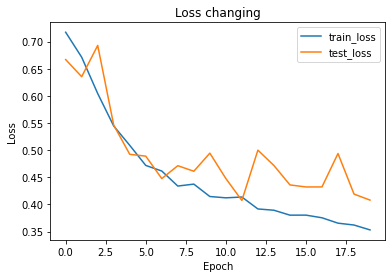

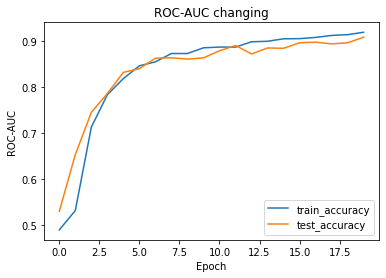

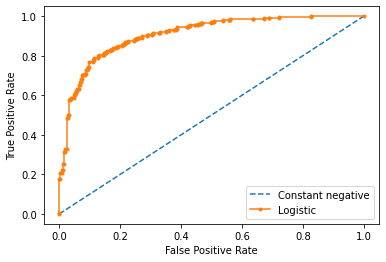

RMS: 2.8955934047698975
Precision score: 0.8449074074074074
Recall score: 0.8924205378973105
Accuracy score: 0.8323262839879154
Balanced accuracy score: 0.8137992017549793
F1 score: 0.868014268727705
F1 weighted score: 0.8306268561431633
AUC-ROC score: 0.9086946857755831


In [275]:
plot_loss_changing(train_loss_history, test_loss_history)
plot_roc_auc_changing(train_roc_auc_history, test_roc_auc_history)
plot_roc_auc(test_labels.cpu().detach().numpy(), test_final_predictions)

cnn1_metrics = getMetrics(test_labels, test_final_predictions)

In [332]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(6, 2), padding=(3, 2))
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(6, 2), padding=(3, 2))
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(6, 2), padding=(3, 2))
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(6, 2), padding=(3, 2))
        self.bn4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(6, 2), padding=(3, 2))
        self.bn5 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(6, 2), padding=(3, 2))
        self.bn6 = nn.BatchNorm2d(1024)
        
        self.conv7 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=(6, 2), padding=(3, 2))
        self.bn7 = nn.BatchNorm2d(2048)
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 2))
        self.avg = nn.AvgPool2d((1, 2))
        self.dropout = nn.Dropout(0.65)
        
        self.fc = nn.Linear(2048, 1)
        
    def forward(self, x):
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn3(self.conv3(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn4(self.conv4(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn5(self.conv5(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn6(self.conv6(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn7(self.conv7(x)))))
        x = self.avg(x)
        x = x.view(-1, 2048)
        x = self.fc(x)
        return x

In [240]:
model_2 = CNN2()
learning_rate = 0.01
device = ("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)
epochs = 20

In [241]:
%%time
(model_2, 
test_final_predictions, 
train_loss_history, 
train_roc_auc_history, 
test_loss_history, 
test_roc_auc_history, 
best_roc_auc) = train(model_2, epochs, train_loader, test_loader, criterion, optimizer)

  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.7335453629493713, Train ROC-AUC = 0.4858020983625507
Test Loss = 0.7185002565383911, Test ROC-AUC = 0.5109989648033126
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.7195058465003967, Train ROC-AUC = 0.5333692486474995
Test Loss = 0.7297480702400208, Test ROC-AUC = 0.47107919254658387



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.7292754054069519, Train ROC-AUC = 0.49460341443176403
Test Loss = 0.7172058820724487, Test ROC-AUC = 0.5087668219461697



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.7198569774627686, Train ROC-AUC = 0.5262604933608271
Test Loss = 0.7285774350166321, Test ROC-AUC = 0.4807194616977226



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.7316466569900513, Train ROC-AUC = 0.49249596984764893
Test Loss = 0.7243715524673462, Test ROC-AUC = 0.46949404761904756



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.7262433171272278, Train ROC-AUC = 0.5146478751137834
Test Loss = 0.7312929630279541, Test ROC-AUC = 0.4715320910973085



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.7202320098876953, Train ROC-AUC = 0.5252924311571543
Test Loss = 0.739331841468811, Test ROC-AUC = 0.4253040890269152



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.7385602593421936, Train ROC-AUC = 0.4616397611425198
Test Loss = 0.7194616794586182, Test ROC-AUC = 0.5056288819875776



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.7322431802749634, Train ROC-AUC = 0.4954166692467898
Test Loss = 0.7120684385299683, Test ROC-AUC = 0.5344202898550725
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.7241570353507996, Train ROC-AUC = 0.5059765972510336
Test Loss = 0.7274749875068665, Test ROC-AUC = 0.46988224637681164



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.7185477614402771, Train ROC-AUC = 0.5347129767809558
Test Loss = 0.7334586977958679, Test ROC-AUC = 0.4563276397515529



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.7172136902809143, Train ROC-AUC = 0.5383292773797508
Test Loss = 0.7138652205467224, Test ROC-AUC = 0.5282738095238095



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.7264937162399292, Train ROC-AUC = 0.5099128331196991
Test Loss = 0.7279601097106934, Test ROC-AUC = 0.47858436853002073



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.7151751518249512, Train ROC-AUC = 0.5431014731471103
Test Loss = 0.7184853553771973, Test ROC-AUC = 0.5011645962732919



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.7262187600135803, Train ROC-AUC = 0.5079251062494712
Test Loss = 0.72588050365448, Test ROC-AUC = 0.483889751552795



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.722854495048523, Train ROC-AUC = 0.5255979177374177
Test Loss = 0.7204378247261047, Test ROC-AUC = 0.48828933747412007



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.7240292429924011, Train ROC-AUC = 0.529251372109488
Test Loss = 0.7255504727363586, Test ROC-AUC = 0.4929800724637681



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.7207579612731934, Train ROC-AUC = 0.5293504488382221
Test Loss = 0.7182877659797668, Test ROC-AUC = 0.4835015527950311



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.7337741255760193, Train ROC-AUC = 0.47542381102765274
Test Loss = 0.7370728254318237, Test ROC-AUC = 0.4612448240165631



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.7185150980949402, Train ROC-AUC = 0.54650517159883
Test Loss = 0.7163110375404358, Test ROC-AUC = 0.5205421842650104

CPU times: user 18h 23min 2s, sys: 1h 7min 16s, total: 19h 30min 19s
Wall time: 1h 48min 1s


In [242]:
test_labels = torch.empty(0, device=device)
for data, label in test_loader:
    test_labels = torch.cat((test_labels, label))
test_labels = torch.squeeze(test_labels)

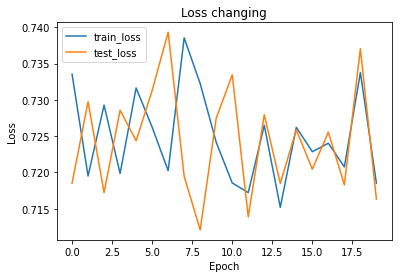

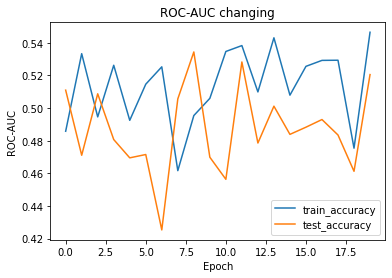

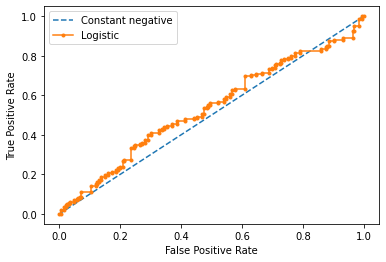

RMS: 0.6784894466400146
Precision score: 0.5079365079365079
Recall score: 0.19875776397515527
Accuracy score: 0.546742209631728
Balanced accuracy score: 0.518649715320911
F1 score: 0.2857142857142857
F1 weighted score: 0.4936701421132439
AUC-ROC score: 0.5344202898550725


In [243]:
plot_loss_changing(train_loss_history, test_loss_history)
plot_roc_auc_changing(train_roc_auc_history, test_roc_auc_history)
plot_roc_auc(test_labels.cpu().detach().numpy(), test_final_predictions)

cnn1_metrics = getMetrics(test_labels, test_final_predictions)

In [333]:
class CNN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 2), padding=(3, 2))
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 2), padding=(3, 2))
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 2), padding=(2, 1))
        self.bn3 = nn.BatchNorm2d(128)
        
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 1), stride=(1, 1))
        self.avg = nn.AvgPool2d((1, 2))
        self.dropout = nn.Dropout(0.5)
        
        self.fc = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn1(self.conv1(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn2(self.conv2(x)))))
        x = self.dropout(self.maxpool(F.leaky_relu(self.bn3(self.conv3(x)))))
        x = self.avg(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [334]:
def full_train_cycle(dataset_annotations_path: str, 
                     dataset_files_path: str,
                     dataset_name: str,
                     model: torch.nn.Module,
                     model_name: str, 
                     device: str, 
                     criterion: torch.nn, 
                     optimizer: torch.optim, 
                     epochs: int) -> Tuple:
    print(f"{dataset_name}:\n")
    df = pd.read_csv(dataset_annotations_path, sep=';')
    WhalesDataset = AudioDataset(df, dataset_files_path)

    indexes = list(range(0, len(WhalesDataset)))

    train_index = indexes[:round(0.8 * len(WhalesDataset))]
    test_index = indexes[round(0.8 * len(WhalesDataset)):]

    train_dataset = AudioDataset(df.iloc[train_index], dataset_files_path)
    test_dataset = AudioDataset(df.iloc[test_index].reset_index(), dataset_files_path)
    
    print(f"Train size = {len(train_dataset)}")
    print(f"Test size = {len(test_dataset)}\n")
    
    train_loader = DataLoader(train_dataset, shuffle=True)
    test_loader = DataLoader(test_dataset, shuffle=False)
    
    (model, 
    test_final_predictions, 
    train_loss_history, 
    train_roc_auc_history, 
    test_loss_history, 
    test_roc_auc_history, 
    best_roc_auc) = train(model, model_name, epochs, train_loader, test_loader, criterion, optimizer)
    
    test_labels = torch.empty(0, device=device)
    for data, label in test_loader:
        test_labels = torch.cat((test_labels, label))
    test_labels = torch.squeeze(test_labels)
    
    plot_loss_changing(train_loss_history, test_loss_history)
    plot_roc_auc_changing(train_roc_auc_history, test_roc_auc_history)
    plot_roc_auc(test_labels.cpu().detach().numpy(), test_final_predictions)
    
    print(f"Total results for {model_name} on {dataset_name}:\n")

    metrics = getMetrics(test_labels, test_final_predictions)
    
    return model, metrics

## A->A

In [368]:
model_A1 = CNN1()

train_config_A1 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/",
    "dataset_name": "A->A",
    "model": model_A1,
    "model_name": "5LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_A1.parameters(), lr=0.01),
    "epochs": 20
}

A->A:

Train size = 1414
Test size = 353



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.8595855832099915, Train ROC-AUC = 0.4731429821682529
Test Loss = 0.6906042695045471, Test ROC-AUC = 0.5067287784679089
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6927199363708496, Train ROC-AUC = 0.5046359652653502
Test Loss = 0.7192773818969727, Test ROC-AUC = 0.5543801759834369
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6932803988456726, Train ROC-AUC = 0.4902502306630091
Test Loss = 0.690558910369873, Test ROC-AUC = 0.5357789855072463



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.686340868473053, Train ROC-AUC = 0.5138119152150894
Test Loss = 0.7012307047843933, Test ROC-AUC = 0.5148809523809524



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6966597437858582, Train ROC-AUC = 0.5035058713282268
Test Loss = 0.6950060725212097, Test ROC-AUC = 0.5228713768115941



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.7007336020469666, Train ROC-AUC = 0.487440992583694
Test Loss = 0.7128279805183411, Test ROC-AUC = 0.49592391304347827



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6937001943588257, Train ROC-AUC = 0.49872748326532124
Test Loss = 0.693024754524231, Test ROC-AUC = 0.47340838509316774



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.7009005546569824, Train ROC-AUC = 0.5250158419561048
Test Loss = 0.721532940864563, Test ROC-AUC = 0.5328027950310559



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6921902298927307, Train ROC-AUC = 0.4732812767687776
Test Loss = 0.6918081641197205, Test ROC-AUC = 0.5127458592132506



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6910800337791443, Train ROC-AUC = 0.4668928918639429
Test Loss = 0.7058236598968506, Test ROC-AUC = 0.5417960662525879



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.6922250390052795, Train ROC-AUC = 0.48779808162683985
Test Loss = 0.6955305337905884, Test ROC-AUC = 0.46337991718426497



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.694974422454834, Train ROC-AUC = 0.4641435126415714
Test Loss = 0.7413280010223389, Test ROC-AUC = 0.4376293995859213



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.6905831098556519, Train ROC-AUC = 0.47163825435060364
Test Loss = 0.693055272102356, Test ROC-AUC = 0.49246247412008287



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.6954329013824463, Train ROC-AUC = 0.48285043748568035
Test Loss = 0.7279576659202576, Test ROC-AUC = 0.5289531573498965



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.7028725743293762, Train ROC-AUC = 0.4746848637591775
Test Loss = 0.6909683346748352, Test ROC-AUC = 0.5211568322981366



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.6929179430007935, Train ROC-AUC = 0.484175588732499
Test Loss = 0.7098861336708069, Test ROC-AUC = 0.5646027432712215
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.6939290165901184, Train ROC-AUC = 0.4825263740187792
Test Loss = 0.6924062371253967, Test ROC-AUC = 0.45804218426501037



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.6898074150085449, Train ROC-AUC = 0.5157728088046186
Test Loss = 0.7330076694488525, Test ROC-AUC = 0.473537784679089



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.6981908082962036, Train ROC-AUC = 0.49669641032627204
Test Loss = 0.6896989345550537, Test ROC-AUC = 0.5076669254658385



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.6945164203643799, Train ROC-AUC = 0.4792444573794618
Test Loss = 0.694641649723053, Test ROC-AUC = 0.4982531055900621



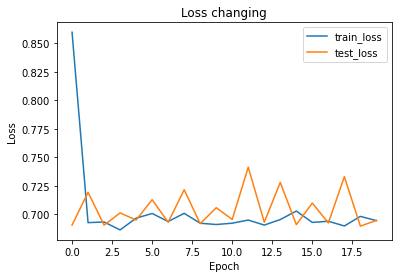

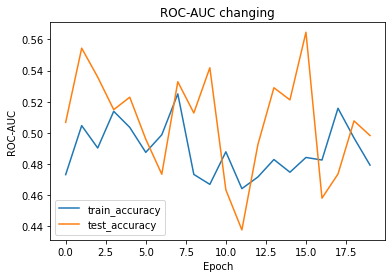

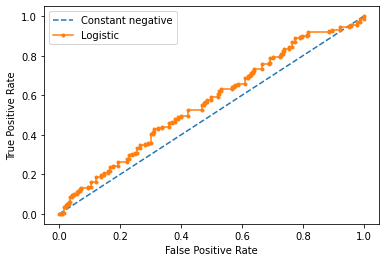

Total results for 5LayerCNN on A->A:

RMS: 1.1911765336990356
Precision score: 0.0
Recall score: 0.0
Accuracy score: 0.5439093484419264
Balanced accuracy score: 0.5
F1 score: 0.0
F1 weighted score: 0.38323154092054995
AUC-ROC score: 0.5646027432712215
CPU times: user 5h 49s, sys: 3min 12s, total: 5h 4min 1s
Wall time: 27min 29s


In [369]:
%%time
(model_A1, metrics_A1) = full_train_cycle(**train_config_A1)

In [340]:
model_A2 = CNN2()

train_config_A2 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/",
    "dataset_name": "A->A",
    "model": model_A2,
    "model_name": "7LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_A2.parameters(), lr=0.01),
    "epochs": 20
}

A->A:

Train size = 1414
Test size = 353



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 1.9774320125579834, Train ROC-AUC = 0.4896041678277221
Test Loss = 0.9387539625167847, Test ROC-AUC = 0.47945781573498963



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.8548313975334167, Train ROC-AUC = 0.5464597614314936
Test Loss = 0.7496374249458313, Test ROC-AUC = 0.4517986542443064



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.7868771553039551, Train ROC-AUC = 0.532923403368196
Test Loss = 0.6944934129714966, Test ROC-AUC = 0.5223537784679089
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.7930218577384949, Train ROC-AUC = 0.5087445533600428
Test Loss = 0.7920375466346741, Test ROC-AUC = 0.41333462732919257



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.7722359895706177, Train ROC-AUC = 0.47329778955690005
Test Loss = 0.6949903964996338, Test ROC-AUC = 0.5563211697722567
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.7996271252632141, Train ROC-AUC = 0.5041849597397584
Test Loss = 0.9207566380500793, Test ROC-AUC = 0.495794513457557



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.8066735863685608, Train ROC-AUC = 0.49063002478982315
Test Loss = 0.8769938349723816, Test ROC-AUC = 0.4762875258799172



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.7552565932273865, Train ROC-AUC = 0.4635428599736208
Test Loss = 0.7274565696716309, Test ROC-AUC = 0.49983825051759834



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.7883347272872925, Train ROC-AUC = 0.5111739973125438
Test Loss = 0.7738989591598511, Test ROC-AUC = 0.5248123706004141



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.8056936860084534, Train ROC-AUC = 0.5208092091819357
Test Loss = 0.8714635968208313, Test ROC-AUC = 0.5410843685300206



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.7884215712547302, Train ROC-AUC = 0.5465877355394418
Test Loss = 0.8554202318191528, Test ROC-AUC = 0.5262681159420289



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.7924015522003174, Train ROC-AUC = 0.5137025179937789
Test Loss = 0.7224368453025818, Test ROC-AUC = 0.505175983436853



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.7578575015068054, Train ROC-AUC = 0.5240436515554014
Test Loss = 0.826789379119873, Test ROC-AUC = 0.4544189958592132



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.7903347611427307, Train ROC-AUC = 0.5188194182131924
Test Loss = 0.7455123662948608, Test ROC-AUC = 0.520995082815735



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.7897402048110962, Train ROC-AUC = 0.5378731116078709
Test Loss = 1.3483728170394897, Test ROC-AUC = 0.4592391304347826



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.8062364459037781, Train ROC-AUC = 0.5258868915295589
Test Loss = 0.7156012654304504, Test ROC-AUC = 0.5240036231884058



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.7524200081825256, Train ROC-AUC = 0.5328201984424312
Test Loss = 1.006239414215088, Test ROC-AUC = 0.4934976708074534



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.798933207988739, Train ROC-AUC = 0.5574077399566126
Test Loss = 1.4081424474716187, Test ROC-AUC = 0.5146221532091098



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.808268129825592, Train ROC-AUC = 0.5534591194968554
Test Loss = 0.7573249340057373, Test ROC-AUC = 0.5736607142857142
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.7991365194320679, Train ROC-AUC = 0.5475671502849488
Test Loss = 0.7058279514312744, Test ROC-AUC = 0.5044319358178053



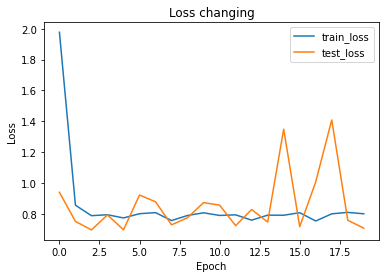

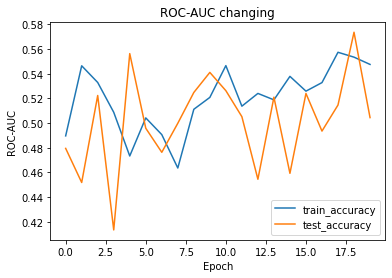

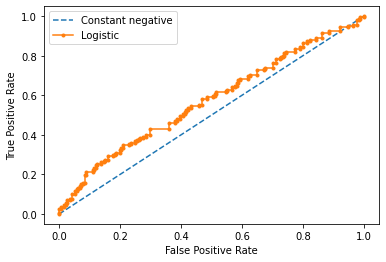

Total results for 7LayerCNN on A->A:

RMS: 1.456187129020691
Precision score: 0.6415094339622641
Recall score: 0.2111801242236025
Accuracy score: 0.5864022662889519
Balanced accuracy score: 0.5561108954451346
F1 score: 0.31775700934579443
F1 weighted score: 0.5274313562282589
AUC-ROC score: 0.5736607142857142
CPU times: user 1d 13h 18min 11s, sys: 2h 24min 38s, total: 1d 15h 42min 49s
Wall time: 3h 42min 19s


In [341]:
%%time
(model_A2, metrics_A2) = full_train_cycle(**train_config_A2)

In [336]:
model_A3 = CNN3()

train_config_A3 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/annotations_A_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_A/train/audio/",
    "dataset_name": "A->A",
    "model": model_A3,
    "model_name": "3LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_A3.parameters(), lr=0.01),
    "epochs": 20
}

A->A:

Train size = 1414
Test size = 353



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.699826180934906, Train ROC-AUC = 0.5098426537701791
Test Loss = 0.6912330985069275, Test ROC-AUC = 0.5802277432712215
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6761521100997925, Train ROC-AUC = 0.5293896667100128
Test Loss = 0.6853012442588806, Test ROC-AUC = 0.6284290890269152
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6641636490821838, Train ROC-AUC = 0.6011356670031147
Test Loss = 0.6982614994049072, Test ROC-AUC = 0.5875711697722567



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.6572883129119873, Train ROC-AUC = 0.6156049975953253
Test Loss = 0.6842024326324463, Test ROC-AUC = 0.5684200310559007



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6515411734580994, Train ROC-AUC = 0.6336514109145401
Test Loss = 0.6824207305908203, Test ROC-AUC = 0.5986995341614907



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6519390344619751, Train ROC-AUC = 0.6379447358263516
Test Loss = 0.6956032514572144, Test ROC-AUC = 0.5718491200828157



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6452488899230957, Train ROC-AUC = 0.6495325848912118
Test Loss = 0.7104066014289856, Test ROC-AUC = 0.5545742753623188



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.6383875608444214, Train ROC-AUC = 0.6545153187071312
Test Loss = 0.7141647338867188, Test ROC-AUC = 0.5717520703933747



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6320292353630066, Train ROC-AUC = 0.670959991578478
Test Loss = 0.715894877910614, Test ROC-AUC = 0.5746959109730848



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6324095726013184, Train ROC-AUC = 0.6744627667589319
Test Loss = 0.6946578621864319, Test ROC-AUC = 0.5824598861283643



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.6420282125473022, Train ROC-AUC = 0.6521498618086043
Test Loss = 0.6735982298851013, Test ROC-AUC = 0.6193711180124224



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.6246905326843262, Train ROC-AUC = 0.684322965366491
Test Loss = 0.6881048083305359, Test ROC-AUC = 0.6050077639751552



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.6163040995597839, Train ROC-AUC = 0.6996034866752119
Test Loss = 0.6508159041404724, Test ROC-AUC = 0.6597437888198758
Model saved successfully



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.5920572876930237, Train ROC-AUC = 0.7389493325737451
Test Loss = 0.6887049078941345, Test ROC-AUC = 0.6396868530020703



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.617498517036438, Train ROC-AUC = 0.700705715282379
Test Loss = 0.7153380513191223, Test ROC-AUC = 0.5334497929606624



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.6467635035514832, Train ROC-AUC = 0.6471526793030777
Test Loss = 0.7820152640342712, Test ROC-AUC = 0.546001552795031



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.6301411390304565, Train ROC-AUC = 0.6761037250785905
Test Loss = 0.7014682292938232, Test ROC-AUC = 0.5683876811594202



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.6289471387863159, Train ROC-AUC = 0.6757920462027812
Test Loss = 0.7058048248291016, Test ROC-AUC = 0.5820716873706004



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.6326799988746643, Train ROC-AUC = 0.6722933992193578
Test Loss = 0.702886700630188, Test ROC-AUC = 0.5728196169772256



  0%|          | 0/1414 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.6183075308799744, Train ROC-AUC = 0.7018574822539131
Test Loss = 0.696262001991272, Test ROC-AUC = 0.5910326086956522



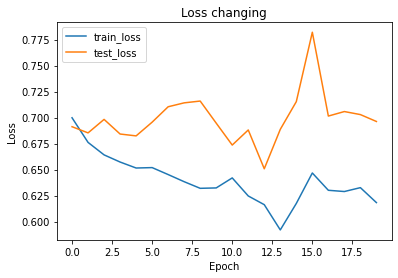

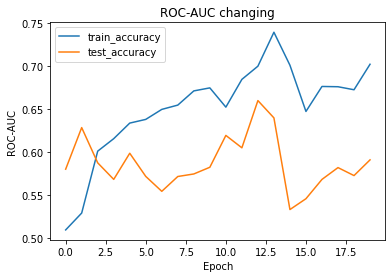

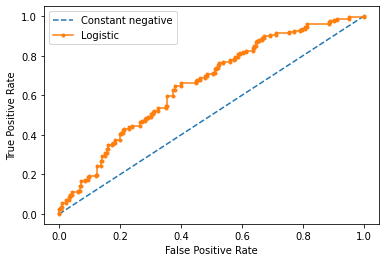

Total results for 3LayerCNN on A->A:

RMS: 1.0319017171859741
Precision score: 0.6
Recall score: 0.2236024844720497
Accuracy score: 0.5779036827195467
Balanced accuracy score: 0.5493012422360248
F1 score: 0.3257918552036199
F1 weighted score: 0.5254020444121063
AUC-ROC score: 0.6597437888198758
CPU times: user 3h 47min 44s, sys: 2min 5s, total: 3h 49min 49s
Wall time: 20min 26s


In [337]:
%%time
(model_A3, metrics_A3) = full_train_cycle(**train_config_A3)

#### Ensemble on A->A

In [411]:
test_predictions = torch.empty(0, device=device)
test_labels = torch.empty(0, device=device)
with torch.no_grad():
    for data, label in tqdm(test_loader, total=len(test_loader)):
        data, label = data.to(device).float(), label.to(device).float()
        predictions = torch.as_tensor((0.5 * torch.as_tensor(model_A3(data)[0]) + 0.5 * torch.as_tensor(model_A2(data)[0])))
        test_predictions = torch.cat((test_predictions, predictions))
        test_labels = torch.cat((test_labels, label))
    test_predictions = torch.squeeze(test_predictions)
    test_labels = torch.squeeze(test_labels)

  0%|          | 0/662 [00:00<?, ?it/s]

In [412]:
threshold = find_best_threshold(test_labels.cpu().detach().numpy(), test_predictions.cpu().detach().numpy())[1]

In [413]:
threshold

0.4493103448275862

In [414]:
metrics_AA = getMetrics(test_labels.cpu().detach().numpy(), test_predictions.cpu().detach().numpy(), threshold=threshold)

RMS: 8.67172908782959
Precision score: 0.0
Recall score: 0.0
Accuracy score: 0.37613293051359514
Balanced accuracy score: 0.49209486166007904
F1 score: 0.0
F1 weighted score: 0.20891686371007595
AUC-ROC score: 0.5721947872474076


## B->B

In [342]:
model_B1 = CNN1()

train_config_B1 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/",
    "dataset_name": "B->B",
    "model": model_B1,
    "model_name": "5LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_B1.parameters(), lr=0.01),
    "epochs": 20
}

B->B:

Train size = 2647
Test size = 662



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.754057765007019, Train ROC-AUC = 0.504020821595905
Test Loss = 0.6715832948684692, Test ROC-AUC = 0.48839838804758545



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.6816446781158447, Train ROC-AUC = 0.4930905672006896
Test Loss = 0.6641846299171448, Test ROC-AUC = 0.5422750949486359
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6808967590332031, Train ROC-AUC = 0.4802251419325947
Test Loss = 0.6672623157501221, Test ROC-AUC = 0.47247214356813594



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.6884258985519409, Train ROC-AUC = 0.49195053185598236
Test Loss = 0.6713864207267761, Test ROC-AUC = 0.5123360746832629



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6841139197349548, Train ROC-AUC = 0.489215410099726
Test Loss = 1.1790401935577393, Test ROC-AUC = 0.48453279472733074



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6897128820419312, Train ROC-AUC = 0.5100592770225696
Test Loss = 0.7181786894798279, Test ROC-AUC = 0.5126163301989815



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6863160729408264, Train ROC-AUC = 0.5017594104079087
Test Loss = 0.6651723980903625, Test ROC-AUC = 0.5113986683031011



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.6840192079544067, Train ROC-AUC = 0.5136819289349879
Test Loss = 0.6668105721473694, Test ROC-AUC = 0.501425437536844



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6849935054779053, Train ROC-AUC = 0.4901285218304128
Test Loss = 0.6637662053108215, Test ROC-AUC = 0.5345439083081264



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6913385391235352, Train ROC-AUC = 0.4997502034487574
Test Loss = 0.6680753231048584, Test ROC-AUC = 0.48486137015955233



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.685032308101654, Train ROC-AUC = 0.5140307412276266
Test Loss = 0.671408474445343, Test ROC-AUC = 0.5657392464025821
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.6862371563911438, Train ROC-AUC = 0.484593271022637
Test Loss = 0.667648434638977, Test ROC-AUC = 0.4919547339022198



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.6828055381774902, Train ROC-AUC = 0.5204140964708261
Test Loss = 0.6929274201393127, Test ROC-AUC = 0.5113116924533955



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.6771132946014404, Train ROC-AUC = 0.5040244331123085
Test Loss = 0.6701954007148743, Test ROC-AUC = 0.520879035921026



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.6820880174636841, Train ROC-AUC = 0.501696810790248
Test Loss = 0.7012906074523926, Test ROC-AUC = 0.4776617026005779



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.6903098225593567, Train ROC-AUC = 0.5032786549749843
Test Loss = 0.7130946516990662, Test ROC-AUC = 0.5630140031118026



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.6845102906227112, Train ROC-AUC = 0.5051921567494426
Test Loss = 0.6514835357666016, Test ROC-AUC = 0.5617673492660205



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.673331618309021, Train ROC-AUC = 0.5567032152126702
Test Loss = 0.6771178841590881, Test ROC-AUC = 0.5812499396001043
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.6718325018882751, Train ROC-AUC = 0.5622589312800659
Test Loss = 0.6219800114631653, Test ROC-AUC = 0.6235975144234951
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.6397483348846436, Train ROC-AUC = 0.6298701298701299
Test Loss = 0.6166971921920776, Test ROC-AUC = 0.6958067976458536
Model saved successfully



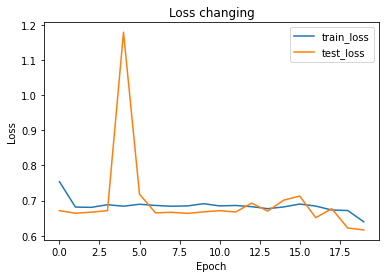

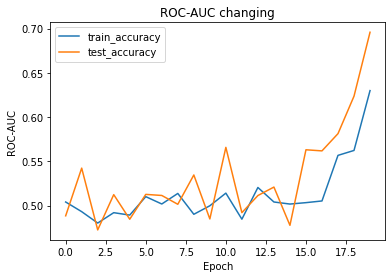

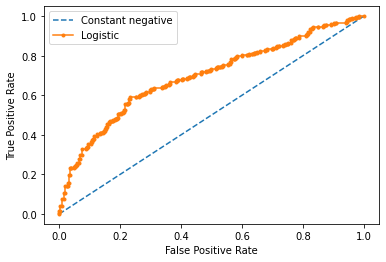

Total results for 5LayerCNN on B->B:

RMS: 1.0489025115966797
Precision score: 0.8453038674033149
Recall score: 0.3740831295843521
Accuracy score: 0.5709969788519638
Balanced accuracy score: 0.6317055964127294
F1 score: 0.5186440677966102
F1 weighted score: 0.5547347666985297
AUC-ROC score: 0.6958067976458536
CPU times: user 9h 53s, sys: 5min 49s, total: 9h 6min 43s
Wall time: 48min 53s


In [343]:
%%time
(model_B1, metrics_B1) = full_train_cycle(**train_config_B1)

In [348]:
model_B2 = CNN2()

train_config_B2 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/",
    "dataset_name": "B->B",
    "model": model_B2,
    "model_name": "7LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_B2.parameters(), lr=0.01),
    "epochs": 10
}

B->B:

Train size = 2647
Test size = 662



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 1.442514181137085, Train ROC-AUC = 0.5087759848605232
Test Loss = 0.796195387840271, Test ROC-AUC = 0.47791296616639445



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.7452848553657532, Train ROC-AUC = 0.4962482363761563
Test Loss = 0.7085152268409729, Test ROC-AUC = 0.4566038829884902



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.7782787084579468, Train ROC-AUC = 0.498516268677559
Test Loss = 0.8848074674606323, Test ROC-AUC = 0.4980623713482223



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.8075349926948547, Train ROC-AUC = 0.5219170892140859
Test Loss = 0.8291708827018738, Test ROC-AUC = 0.5201639011567788
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.7837232947349548, Train ROC-AUC = 0.5350148553708064
Test Loss = 0.7359647154808044, Test ROC-AUC = 0.507571730916049



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.7821635007858276, Train ROC-AUC = 0.49233154683655245
Test Loss = 0.7828173041343689, Test ROC-AUC = 0.5179025290644298



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.8018876910209656, Train ROC-AUC = 0.5057218458219571
Test Loss = 0.783173143863678, Test ROC-AUC = 0.5017733409356668



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.7778753638267517, Train ROC-AUC = 0.5019147056132596
Test Loss = 0.8351902365684509, Test ROC-AUC = 0.46738888835200093



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.7634084820747375, Train ROC-AUC = 0.4768513836923181
Test Loss = 0.6883828639984131, Test ROC-AUC = 0.5088667046783343



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.7902519106864929, Train ROC-AUC = 0.5111427319436218
Test Loss = 0.7522606253623962, Test ROC-AUC = 0.49254423688355864



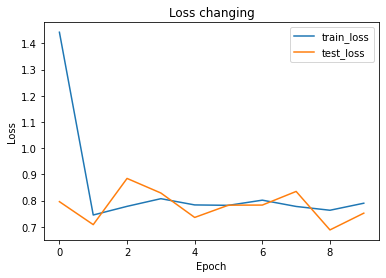

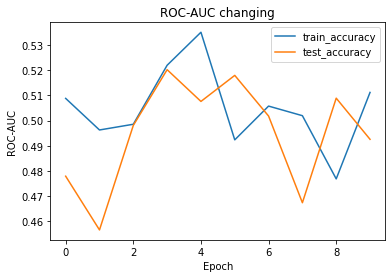

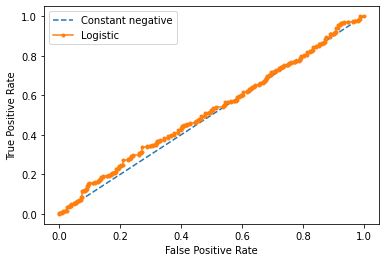

Total results for 7LayerCNN on B->B:

RMS: 1.461524486541748
Precision score: 0.6171171171171171
Recall score: 0.6699266503667481
Accuracy score: 0.5392749244712991
Balanced accuracy score: 0.49899494573673375
F1 score: 0.6424384525205159
F1 weighted score: 0.5316088448922702
AUC-ROC score: 0.5201639011567788
CPU times: user 1d 10h 21min 49s, sys: 2h 58min 56s, total: 1d 13h 20min 45s
Wall time: 3h 30min 28s


In [349]:
%%time
(model_B2, metrics_B2) = full_train_cycle(**train_config_B2)

In [350]:
model_B3 = CNN3()

train_config_B3 = {
    "dataset_annotations_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/annotations_B_train.csv",
    "dataset_files_path": "/home/latna/aponom/whales/Canada/data/clips/dataset_B/train/audio/",
    "dataset_name": "B->B",
    "model": model_B3,
    "model_name": "3LayerCNN",
    "device": "cpu",
    "criterion": nn.BCEWithLogitsLoss(),
    "optimizer": optim.Adam(model_B3.parameters(), lr=0.01),
    "epochs": 20
}

B->B:

Train size = 2647
Test size = 662



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 1
Train Loss = 0.6759170293807983, Train ROC-AUC = 0.4930418117292422
Test Loss = 0.6656568646430969, Test ROC-AUC = 0.5110411009209777
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 2
Train Loss = 0.66923987865448, Train ROC-AUC = 0.48915461624026696
Test Loss = 0.665445864200592, Test ROC-AUC = 0.554886593155967
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 3
Train Loss = 0.6694100499153137, Train ROC-AUC = 0.49683270011412395
Test Loss = 0.666229248046875, Test ROC-AUC = 0.5215361867854692



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 4
Train Loss = 0.6807494759559631, Train ROC-AUC = 0.49413670311890556
Test Loss = 0.6664308905601501, Test ROC-AUC = 0.5060351575712476



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 5
Train Loss = 0.6706677079200745, Train ROC-AUC = 0.5013874242183475
Test Loss = 0.6657573580741882, Test ROC-AUC = 0.49161649448669753



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 6
Train Loss = 0.6701114177703857, Train ROC-AUC = 0.5101712340310782
Test Loss = 0.6642030477523804, Test ROC-AUC = 0.5349884515399557



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 7
Train Loss = 0.6694642901420593, Train ROC-AUC = 0.49071539324598284
Test Loss = 0.664155125617981, Test ROC-AUC = 0.5355972824878958



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 8
Train Loss = 0.6698155999183655, Train ROC-AUC = 0.48824391218718244
Test Loss = 0.6655433177947998, Test ROC-AUC = 0.5296346047914029



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 9
Train Loss = 0.6682465076446533, Train ROC-AUC = 0.5167481063615658
Test Loss = 0.6684355139732361, Test ROC-AUC = 0.492215661451337



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 10
Train Loss = 0.6692720055580139, Train ROC-AUC = 0.5068143295340181
Test Loss = 0.6652061939239502, Test ROC-AUC = 0.5101810064072209



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 11
Train Loss = 0.6677359342575073, Train ROC-AUC = 0.5204333578916449
Test Loss = 0.6609933376312256, Test ROC-AUC = 0.5620669327483403
Model saved successfully



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 12
Train Loss = 0.6667129397392273, Train ROC-AUC = 0.5330646365129124
Test Loss = 0.6653770208358765, Test ROC-AUC = 0.5114276602530031



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 13
Train Loss = 0.6608210802078247, Train ROC-AUC = 0.5627416706393347
Test Loss = 0.6797256469726562, Test ROC-AUC = 0.5535916193936816



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 14
Train Loss = 0.6641518473625183, Train ROC-AUC = 0.5398037261218573
Test Loss = 0.6565086841583252, Test ROC-AUC = 0.5523353015645989



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 15
Train Loss = 0.6599450707435608, Train ROC-AUC = 0.5572431369149946
Test Loss = 0.6573736071586609, Test ROC-AUC = 0.5547802893396601



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 16
Train Loss = 0.6628941297531128, Train ROC-AUC = 0.5412320808594446
Test Loss = 0.6529995799064636, Test ROC-AUC = 0.5594190013239657



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 17
Train Loss = 0.6680619120597839, Train ROC-AUC = 0.5223137540990711
Test Loss = 0.6709914803504944, Test ROC-AUC = 0.48705509436879685



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 18
Train Loss = 0.6655066609382629, Train ROC-AUC = 0.5354416162258209
Test Loss = 0.6630743741989136, Test ROC-AUC = 0.5445557950075862



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 19
Train Loss = 0.6625076532363892, Train ROC-AUC = 0.5456760517939606
Test Loss = 0.6592063307762146, Test ROC-AUC = 0.5474646539810779



  0%|          | 0/2647 [00:00<?, ?it/s]

Epoch: 20
Train Loss = 0.6672167778015137, Train ROC-AUC = 0.5506701770606108
Test Loss = 0.6633524894714355, Test ROC-AUC = 0.5405355779545213



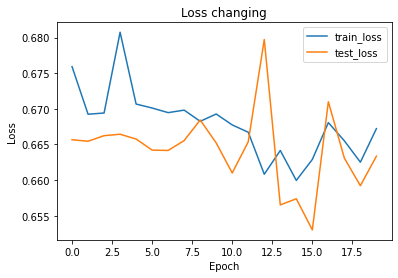

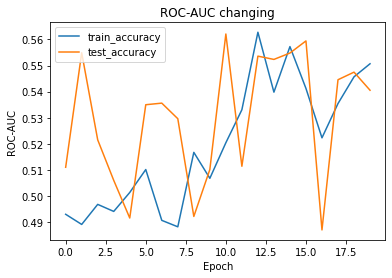

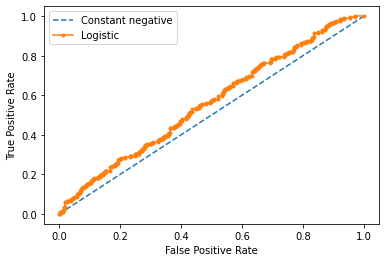

Total results for 3LayerCNN on B->B:

RMS: 0.4878303110599518
Precision score: 0.6456521739130435
Recall score: 0.726161369193154
Accuracy score: 0.5845921450151057
Balanced accuracy score: 0.5409462972447984
F1 score: 0.6835443037974683
F1 weighted score: 0.5735008041405992
AUC-ROC score: 0.5620669327483403
CPU times: user 7h 39min 57s, sys: 3min 21s, total: 7h 43min 18s
Wall time: 41min 26s


In [351]:
%%time
(model_B3, metrics_B3) = full_train_cycle(**train_config_B3)

In [415]:
test_predictions = torch.empty(0, device=device)
test_labels = torch.empty(0, device=device)
with torch.no_grad():
    for data, label in tqdm(test_loader, total=len(test_loader)):
        data, label = data.to(device).float(), label.to(device).float()
        predictions = torch.as_tensor((0.5 * torch.as_tensor(model_B1(data)[0]) + 0.5 * torch.as_tensor(model_B3(data)[0])))
        test_predictions = torch.cat((test_predictions, predictions))
        test_labels = torch.cat((test_labels, label))
    test_predictions = torch.squeeze(test_predictions)
    test_labels = torch.squeeze(test_labels)

  0%|          | 0/662 [00:00<?, ?it/s]

In [416]:
threshold = find_best_threshold(test_labels.cpu().detach().numpy(), test_predictions.cpu().detach().numpy())[1]

In [417]:
threshold

0.04379310344827586

In [418]:
metrics_BB = getMetrics(test_labels.cpu().detach().numpy(), test_predictions.cpu().detach().numpy(), threshold=threshold)

RMS: 0.7258810997009277
Precision score: 0.6331269349845201
Recall score: 1.0
Accuracy score: 0.6419939577039275
Balanced accuracy score: 0.5316205533596838
F1 score: 0.7753554502369668
F1 weighted score: 0.5244970293383873
AUC-ROC score: 0.5568725417242479
